# <a id='toc1_'></a>[Escasez de Ejercicio](#toc0_)

# <a id='toc0_'></a>[Tabla de contenidos](#toc0_)
  
- [Escasez de Ejercicio](#toc1_)    
- [Tabla de contenidos](#toc0_)    
- [Introducción](#toc3_)    
- [Cargar datos y Realizar el EDA](#toc4_)    
- [Construcción de un modelo para la predicción de cancelación de usuarios](#toc5_)    
  - [Modelo de Regresión Logística](#toc5_1_)    
  - [Modelo de Bosque Aleatorio](#toc5_2_)    
  - [Conclusiones de los modelos entrenados](#toc5_3_)    
- [Crear Clusters de usuarios](#toc6_)    
  - [Dendrograma](#toc6_1_)    
  - [Modelo de K-Means](#toc6_2_)    
  - [Observaciones de los Clusters](#toc6_3_)    
- [Conclusiones](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc3_'></a>[Introducción](#toc0_)

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un/a cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos.

Model Fitness te aportó archivos CSV que contienen los datos sobre la cancelación de un mes en concreto e información del mes que lo precedía. 

En este proyecto se buscara:

* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
* identificar a los grupos objetivo;
* sugerir medidas para reducir la rotación;
* describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

Para lograr responder todos los puntos anteriores, el proyecto se dividirá en cuatro pasos: 

1. Cargar datos y Realizar el EDA (Análisis Exploratorio de Datos)
2. Construcción de un modelo para la predicción de cancelación de usuarios
3. Crear clusters de usuarios
4. Conclusiones 

En cada paso mencionado anteriormente se profundizara el procedimiento a llevar a cabo. 

Sin mas que aclarar, procedemos con el proyecto. 

# <a id='toc4_'></a>[Cargar datos y Realizar el EDA](#toc0_)

En este paso cargaremos la librerías que se usaran a lo largo del proyecto, cargaremos los datos proporcionados por la empresa y realizaremos un análisis exploratorio de los datos. 

Comencemos importando las librerías que se usaran a lo largo del proyecto. 

In [1]:
# Importando las librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

Una vez cargadas las librerías a usar, carguemos los datos promocionados por la empresa.

Adicional al archivo proporcionado, se nos otorgo las siguientes descripciones de las columnas:

* `Churn`: la cancelación para el mes en cuestión
* `gender`: Genero del usuario
* `Near_Location`: si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
* `Partner`: si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
* `Promo_friends`: si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
* `Phone`: si el/la usuario/a aportó el número de teléfono.
* `Age`: Edad del usuario. 
* `Lifetime`: el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.
* `Contract_period`: 1 mes, 3 meses, 6 meses o 1 año.
* `Month_to_end_contract`: los meses que faltan hasta que expire el contrato.
* `Group_visits`: si el/la usuario/a participa en sesiones grupales.
* `Avg_class_frequency_total`: frecuencia media de visitas por semana a lo largo de la vida del cliente.
* `Avg_class_frequency_current_month`: frecuencia media de visitas por semana durante el mes en curso.
* `Avg_additional_charges_total`: cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [2]:
# Cargando la información proporcionada
data = pd.read_csv("./datasets/gym_churn_us.csv")

In [3]:

# Primera vista de la información proporcionada
print(data.shape)
print(data.info())
print(data.describe())
print(data.head(5))

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-n

Antes de continuar con el procedimiento, cambiaremos el nombre de las columnas para que todos sus caracteres sean minúsculas respetando la nomenclatura `snake_case`.

In [4]:
# Cambiando los nombres de las columnas
new_col_names = []

for old_name in data.columns:
    # Poniendo todas las letras a minúsculas
    name_lowered = old_name.lower()
    # Agregamos el nuevo nombre a la lista de new_col_names
    new_col_names.append(name_lowered)

# Reemplazamos los nombres anteriores por los nuevos
data.columns = new_col_names

# Corroboramos los cambios
print(data.columns)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


Una vez hecho este cambio, podemos proceder con el desarrollo del proyecto.

De acuerdo a la información obtenida, notamos que no hay información ausente, notamos que todas las columnas contienen información categórica convertida ya en etiquetas binarias, la edad promedio de los usuarios es de 29 años siendo la edad menor de 18 años y la edad mayor de 41, la información proporcionada contiene información de usuarios que en su mayoría lleva en el gimnasio aproximadamente 3 a 4 meses, la gran parte de los usuarios va al gimnasio una vez por semana, el promedio de los usuarios registrados en esta base de datos les queda aproximadamente 4 meses para que termine su contrato. 

Teniendo en cuenta esta información agruparemos por `Churn` para ver las características en promedio de los dos grupos de personas, de los que cancelaron y de los que se quedaron, adicional a esto crearemos histogramas de barras y distribuciones de características para aquellas personas que se fueron y para las que se quedaron. 

         gender  near_location   partner  promo_friends     phone  \
churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       contract_period  group_visits        age  avg_additional_charges_total  \
churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       avg_class_frequency_current_month  
churn                                     
0                               2.0

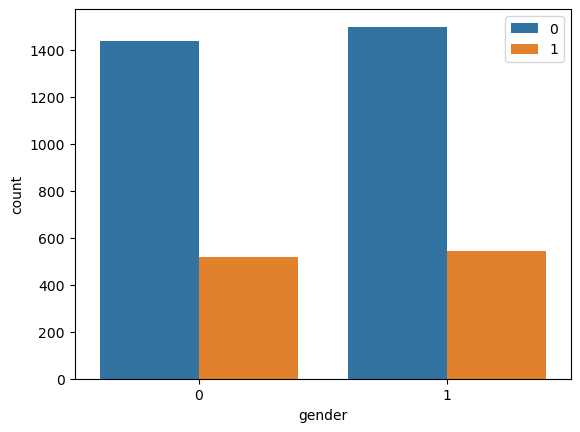

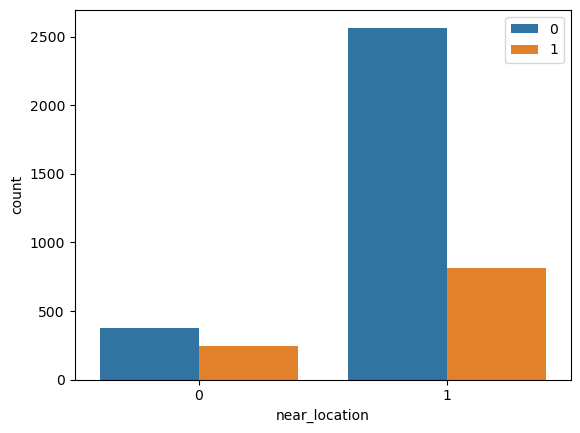

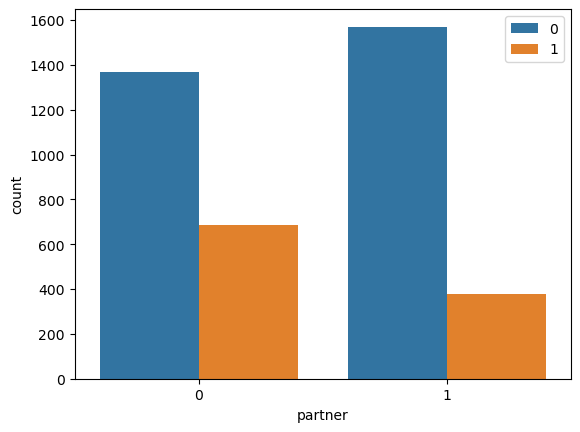

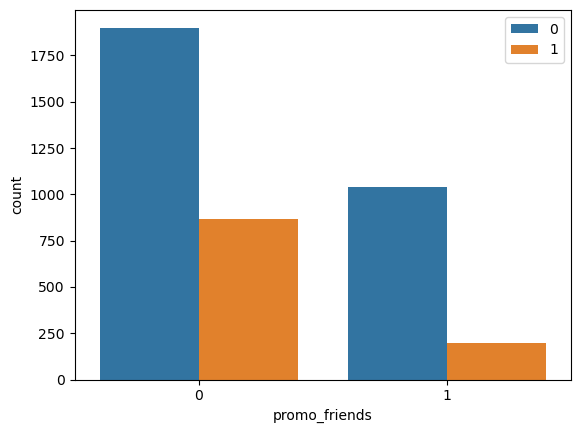

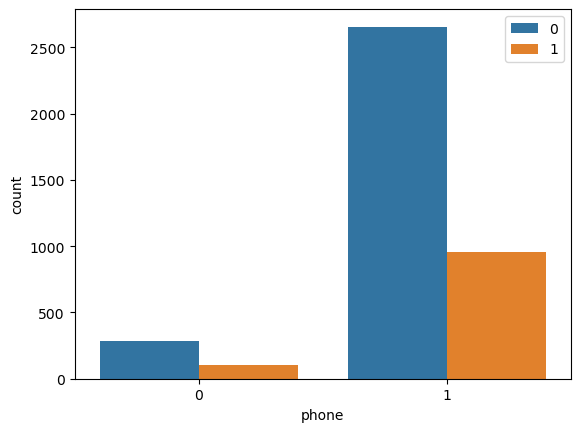

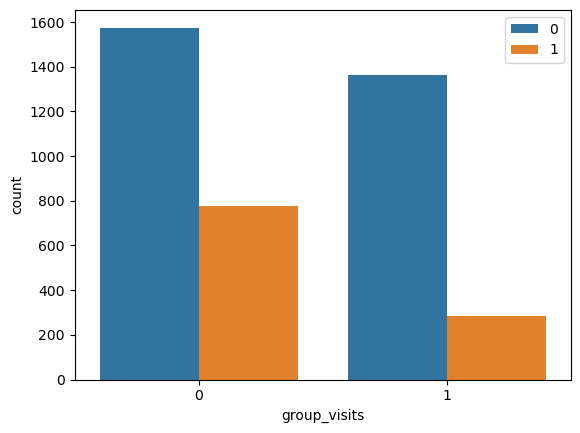

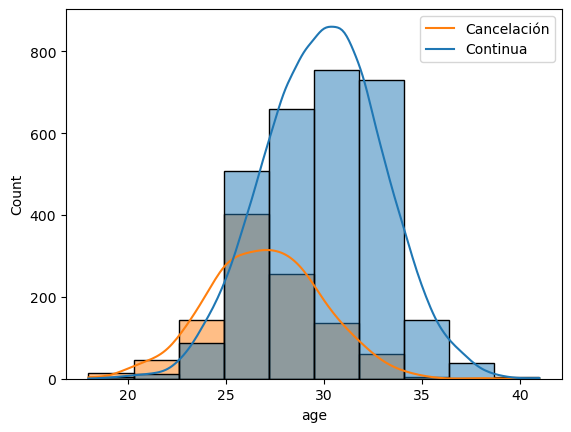

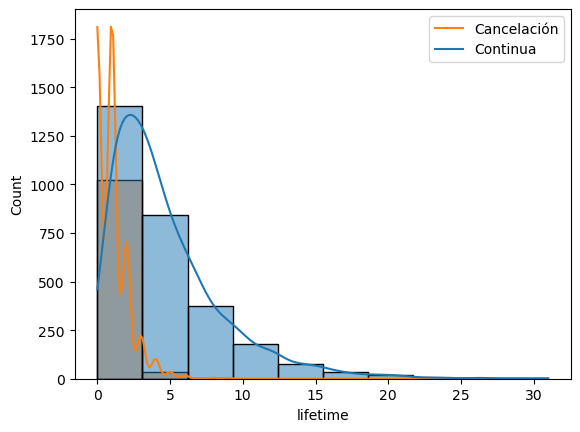

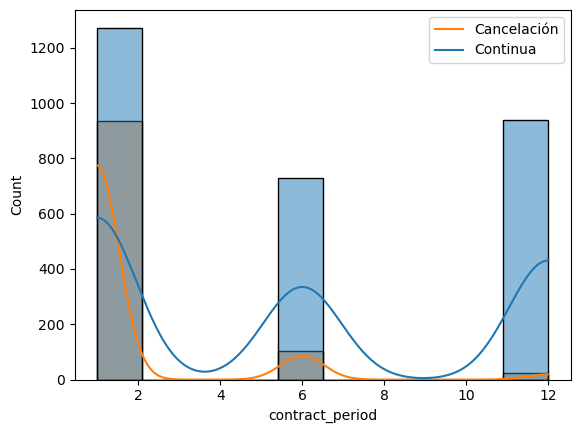

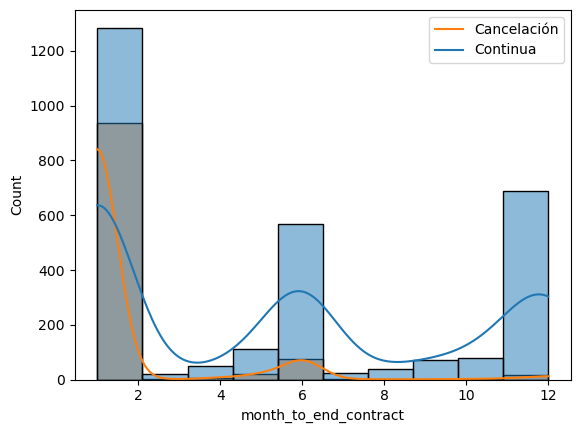

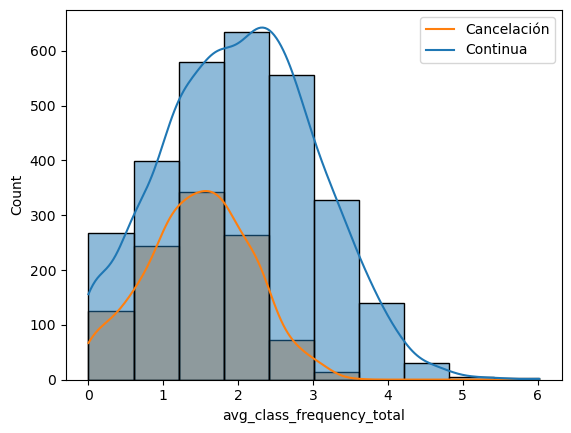

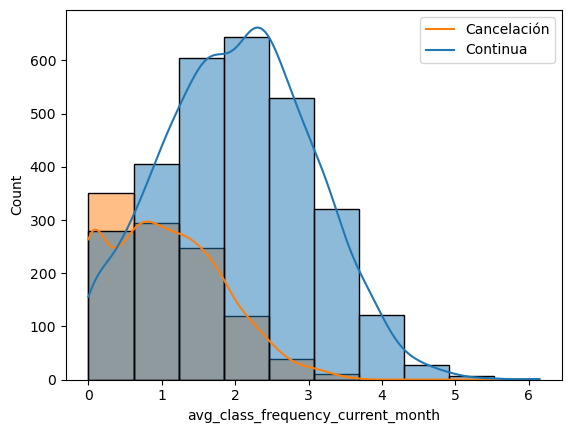

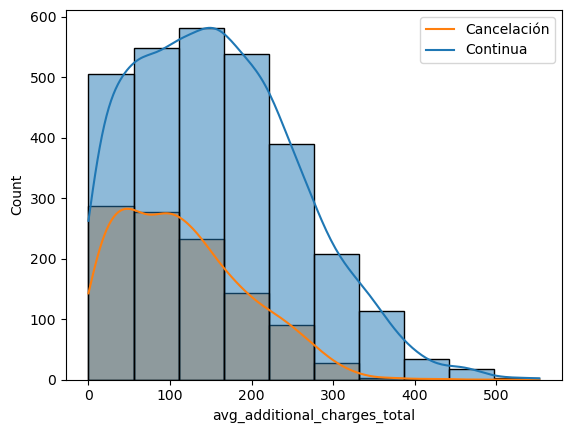

In [5]:
# Agrupando por "Churn"
churn_users = data.groupby('churn').mean()
print(churn_users)

# Creamos listas tomando en cuenta las características binarias y las características con valores continuos
binary_characteristics = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits' ]
continue_characteristics = ['age', 'lifetime', 'contract_period', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']

# Creando gráficas de barras de las características binarias
for characteristic in binary_characteristics:
    sns.countplot(data= data, x=characteristic, hue=data['churn'])
    plt.legend()
    plt.show()

# Gráficando histogramas de las características continuas
for characteristic in continue_characteristics:
    sns.histplot(data = data, x=characteristic, bins = 10, kde=True, hue='churn')
    plt.legend(labels=['Cancelación', 'Continua'])
    plt.show()


Como podemos ver en estos resultados, ya podríamos generar algunas conclusiones, los usuarios que se inscriben al gimnasio sin tener un descuento por alguna compañía asociada tienden a cancelar con mayor frecuencia que los que si tienen algún descuento. Los usuarios que se inscriben al gimnasio con la promoción de "trae a un amigo" no suelen cancelar tanto que los que se inscriben sin esa promoción. Los usuarios que establecen su contrato de 1 mes tienden a cancelar. Los usuarios de 20 a 30 años tienden a cancelar mas seguido. Los usuarios que les queda un mes para que se acabe su contrato tienden a cancelar. Los usuarios que tienden a cancelar los primeros meses de empezar el contrato. Los usuarios que cancelan solían ir de 1 a 3 veces por semana. Los usuarios que no asistieron al gimnasio al mes, tienden a cancelar. 

Adicional a esta información podemos concluir que no hay valores atípicos. A continuación crearemos una matriz de correlación y la mostraremos. 

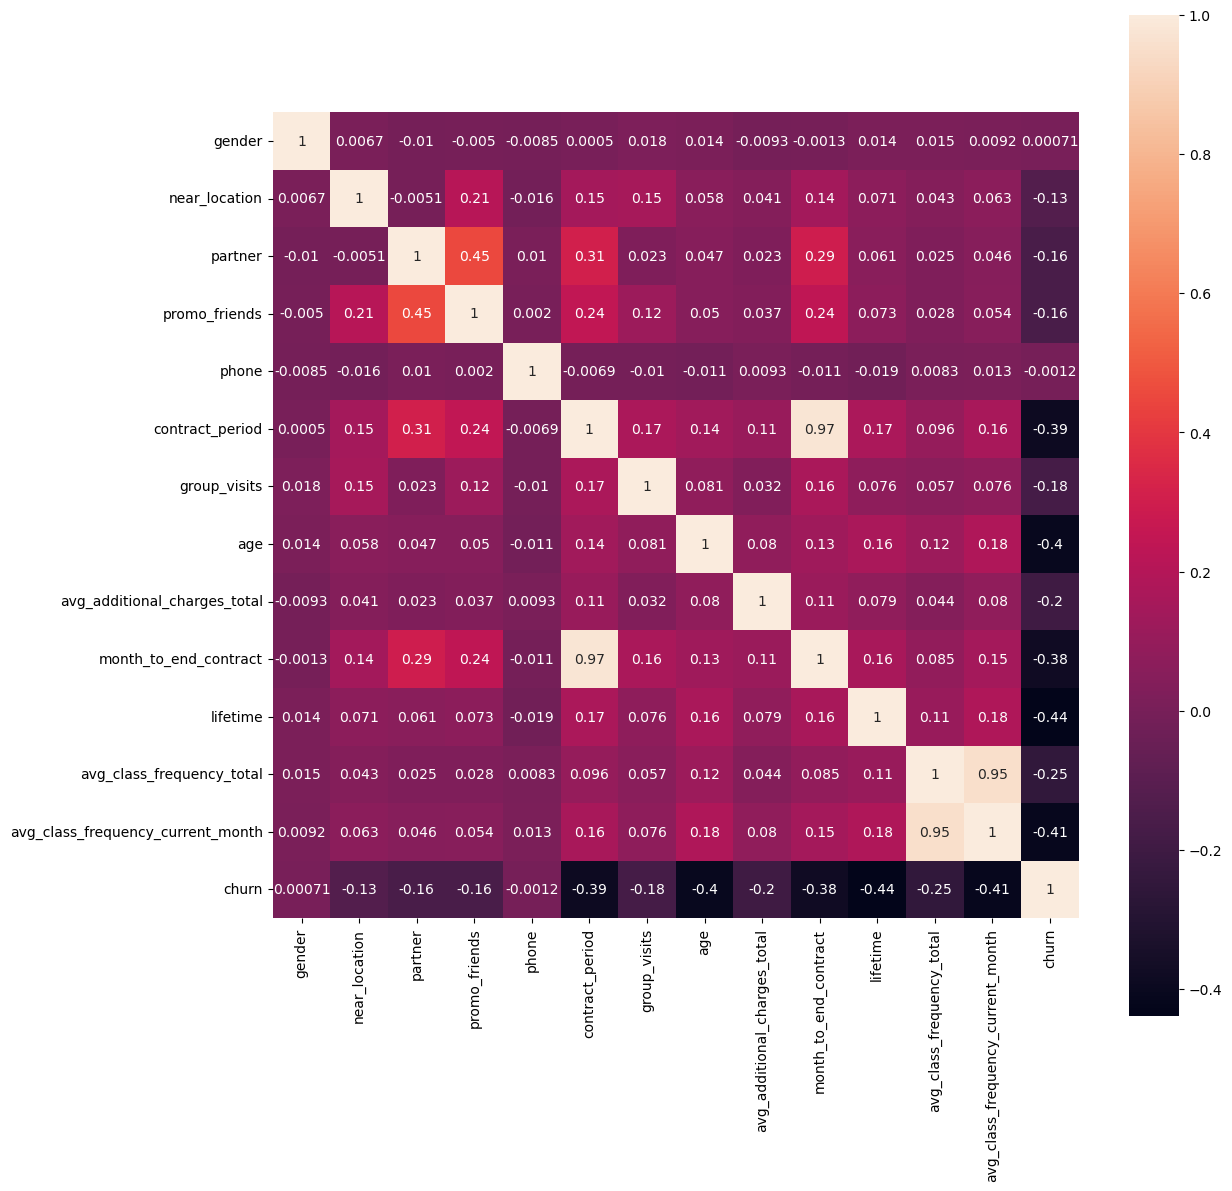

In [6]:
# Creando la matriz de relación
cm = data.corr()

# Trazamos el mapa de calor anotado para la matriz de correlación
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot = True, square=True)
plt.show()

Como podemos ver, ademas de la característica de la edad, no hay muchas características fuertemente correlaciones con la variable "Churn". Sin embargo podemos notar una fuerte correlación entre las características `Avg_class_frequency_total` con `Avg_class_frequency_current_month` y `Contract_period` y `Month_to_end_contract`, tal vez pudiéramos eliminar alguna de las características fuertemente relacionadas para evitar problemas al momento de realizar entrenar al modelo.

Teniendo esta información podemos proceder a la siguiente sección.

# <a id='toc5_'></a>[Construcción de un modelo para la predicción de cancelación de usuarios](#toc0_)

En este apartado se elaborara un modelo de clasificación binaria para clientes donde la característica objetivo (`Churn`) es la marcha del usuario el mes siguiente. 

Para ello se crearán dos modelos con distintos métodos:

* Regresión Logística
* Bosque Aleatorio

Para corroborar la eficiencia de estos dos modelos se usaran las métricas de "Exactitud", "Precision" y "Recall" y en base a estos resultados estableceremos cual de los dos modelos dio mejores resultados. 

Debido a que los resultados de la sección pasada, notamos una correlación muy fuerte entre las características `Avg_class_frequency_total` con `Avg_class_frequency_current_month` y `Contract_period` con `Month_to_end_contract`, eliminaremos una de ellas para evitar problemas en el entrenamiento del modelo. 

In [7]:
# Eliminando las columnas de las características con correlación alta.
data_filtered = data.drop(['avg_class_frequency_total', 'month_to_end_contract'], axis = 1)

# Corroborando el cambio
print(data_filtered.shape)
data_filtered.head(5)

(4000, 12)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


Una vez hecho este cambio, podemos seguir con el procedimiento del desarrollo de los modelos.

In [8]:
# Dividimos los datos en características "X" y una variable objetivo "y" 
X = data_filtered.drop('churn', axis = 1)
y = data_filtered['churn']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

Una vez seccionados los datos, pasamos a estandarizarlos.

In [9]:
# Entrenamos StandardScaler en el conjunto de entrenamiento
scaler = StandardScaler()
scaler.fit(X_train)

# Transformamos conjuntos de entrenamiento y de prueba 
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Una vez estandarizados, pasamos a entrenar los modelos. Sin embargo antes de entrenarlos, establezcamos una función para generar los cálculos de las métricas para que sea mas fácil mas adelante mostrar las métricas:


In [10]:
# Definimos una función que podrá generar nuestras métricas
def print_all_metrics(y_true, y_pred, y_proba, tittle = 'Métricas de clasificación'):
    print(tittle)
    print('\tExactitud: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

Una vez definida la función podemos empezar a entrenar nuestros modelos. 

## <a id='toc5_1_'></a>[Modelo de Regresión Logística](#toc0_)

In [11]:
# Definimos el algoritmo para el modelo de regresión logística
lr_model = LogisticRegression(random_state = 0)
# Entrenamos el modelo
lr_model.fit(X_train_st, y_train)
# Utilizamos el modelo entrenado para hacer previsiones
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# Mostramos todas las métricas
print_all_metrics(y_test, lr_predictions, lr_probabilities, tittle='Métricas de Regresión Lineal')

Métricas de Regresión Lineal
	Exactitud: 0.90
	Precision: 0.79
	Recall: 0.82


Una ves teniendo los resultados de este método procedamos a hacer el modelo de "Bosque Aleatorio".

## <a id='toc5_2_'></a>[Modelo de Bosque Aleatorio](#toc0_)

Para este modelo estableceremos el numero de árboles en 100 y observaremos los resultados. 

In [12]:
# Definimos el algoritmo para el modelo de Bosque Aleatorio
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
# Entrenamos el modelo
rf_model.fit(X_train_st, y_train)
# Utilizamos el modelo entrenado para hacer previsiones
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
# Mostramos todas las métricas
print_all_metrics(y_test, rf_predictions, rf_probabilities, tittle="Métricas de Bosque Aleatorio")

Métricas de Bosque Aleatorio
	Exactitud: 0.90
	Precision: 0.81
	Recall: 0.75


## <a id='toc5_3_'></a>[Conclusiones de los modelos entrenados](#toc0_)

Como podemos ver en los resultados, ambos modelos tienen una Exactitud del 90% lo cual es buena. en cuanto a la precision ambos modelos presentan puntuaciones altas, sin embargo el modelo de Bosque Aleatorio supera al modelo de Regresión Lineal por .03 puntos, en cuanto a la métrica de Recall, vemos que el modelo de Regresión Lineal supera al modelo de Bosque aleatorio por .07 puntos. Realmente no es mucha diferencia, sin embargo tratemos de entrenar al modelo de Bosque Aleatorio cambiando el numero de árboles para ver su comportamiento si es que mejora o empeora. 

In [13]:
# Definimos el algoritmo para el modelo de Bosque Aleatorio
rf_model_2 = RandomForestClassifier(n_estimators=200, random_state=0)
# Entrenamos el modelo
rf_model_2.fit(X_train_st, y_train)
# Utilizamos el modelo entrenado para hacer previsiones
rf_predictions_2 = rf_model.predict(X_test_st)
rf_probabilities_2 = rf_model.predict_proba(X_test_st)[:,1]
# Mostramos todas las métricas
print_all_metrics(y_test, rf_predictions_2, rf_probabilities_2, tittle="Métricas de Bosque Aleatorio 2")

Métricas de Bosque Aleatorio 2
	Exactitud: 0.90
	Precision: 0.81
	Recall: 0.75


In [14]:
# Definimos el algoritmo para el modelo de Bosque Aleatorio
rf_model_3 = RandomForestClassifier(n_estimators=50, random_state=0)
# Entrenamos el modelo
rf_model_3.fit(X_train_st, y_train)
# Utilizamos el modelo entrenado para hacer previsiones
rf_predictions_3 = rf_model.predict(X_test_st)
rf_probabilities_3 = rf_model.predict_proba(X_test_st)[:,1]
# Mostramos todas las métricas
print_all_metrics(y_test, rf_predictions_3, rf_probabilities_3, tittle="Métricas de Bosque Aleatorio 3")

Métricas de Bosque Aleatorio 3
	Exactitud: 0.90
	Precision: 0.81
	Recall: 0.75


Como podemos ver, los resultados cambiando el numero de árboles en el modelo de Bosque Aleatorio no afectan los resultados de las métricas, por lo que por esta ocasión estableceremos al modelo de Regresión Logística como el mejor modelo para esta situación. 

Una vez realizados estos modelos pasaremos al 3er paso del proyecto. 

# <a id='toc6_'></a>[Crear Clusters de usuarios](#toc0_)

Adicional del desarrollo de los modelos para predecir a los posibles usuarios que cancelen, se nos solicito segmentar a los usuarios en grupos, por lo que se creara un modelo para realizar esta tarea. 

Para ello primeramente crearemos un dendrograma para poder visualizar con mayor facilidad cual seria el numero de grupos ideal para este proyecto. 

Después de ello entrenaremos un modelo de clustering con el algoritmo de "K-means" y predijéremos los clusters de clientes.

Ademas de esto observaremos los valores medios de característica para los clusters, trazaremos distribuciones de características para los clusters y calcularemos la tasa de cancelación para cada cluster. 

Aclarado esto empezaremos con el desarrollo de esta sección. 

## <a id='toc6_1_'></a>[Dendrograma](#toc0_)

Para generar un dendrograma primeramente estandarizaremos los datos a usar y usaremos el método linkage para trazar el gráfico. 

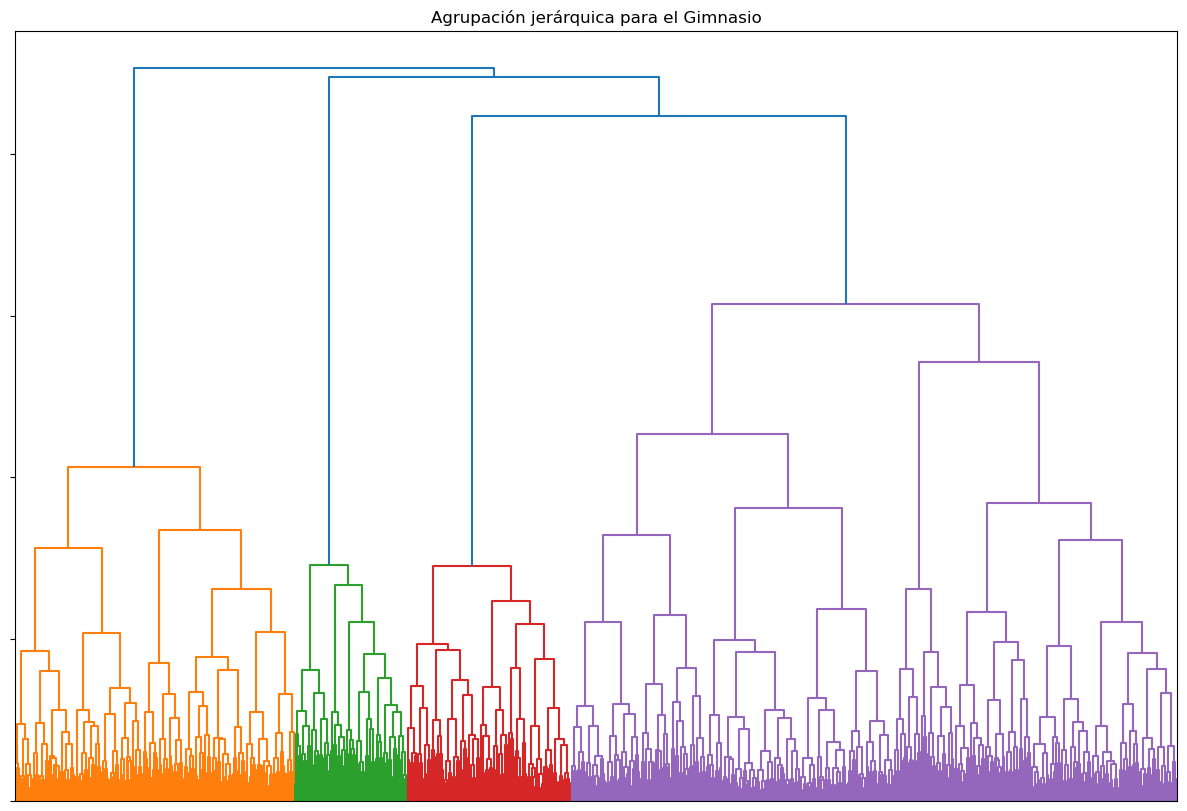

In [15]:
# Estandarización de los datos
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

# Trazamos el gráfico
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para el Gimnasio')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

Como podemos ver, se nos recomienda que se usen cuatro grupos (hay cuatro colores al final de las ramas), sin embargo estableceremos el numero de clusters en 5. 

## <a id='toc6_2_'></a>[Modelo de K-Means](#toc0_)

In [16]:
# Definimos el modelo de K-Means con 5 clusters
km = KMeans(n_clusters=5)
# Predice los clusters para las observaciones
labels = km.fit_predict(X_sc)

# Almacenamos las etiquetas de cluster en el campo de nuestro conjunto de datos
data_filtered['cluster_km'] = labels

# Imprimimos las primeras 5 filas de nuestro Dataframe
data_filtered.head(5)

c:\Users\PepeJ\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\PepeJ\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PepeJ\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,4
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,1
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,1


Una vez establecidos los clusters pasemos a las observaciones de las características.

## <a id='toc6_3_'></a>[Observaciones de los Clusters](#toc0_)

Primeramente veamos los valores promedio de las diferentes características para cada grupo. 

In [17]:
# Agrupamos por cluster y veamos los valores medios
clusters = data_filtered.groupby('cluster_km').mean().reset_index()

clusters.sort_values(by='churn', ascending=False)

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
2,2,0.489635,1.000000,0.272458,0.121422,1.0,2.043435,0.268509,27.333662,116.790873,1.738401,1.105058,0.612043
0,0,0.500000,0.000000,0.489286,0.076786,1.0,3.026786,0.235714,28.717857,136.943259,3.028571,1.603604,0.400000
3,3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
1,1,0.494526,0.995438,0.955292,0.814781,1.0,8.212591,0.528285,29.720803,154.881430,4.258212,1.962576,0.079380
4,4,0.551323,0.998942,0.177778,0.060317,1.0,4.354497,0.530159,30.775661,177.103838,5.559788,2.364372,0.028571


Una vez declarada la función creemos una lista con los nombres de las características a representar.

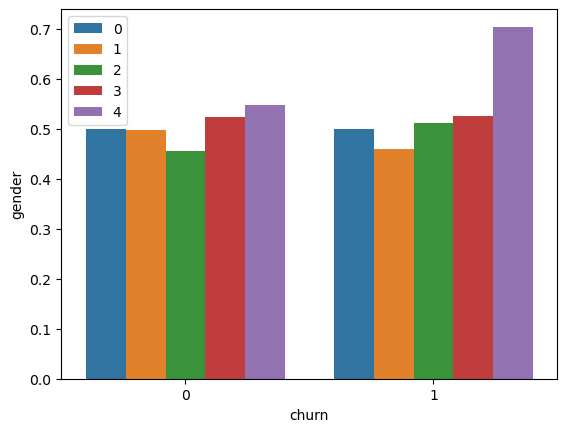

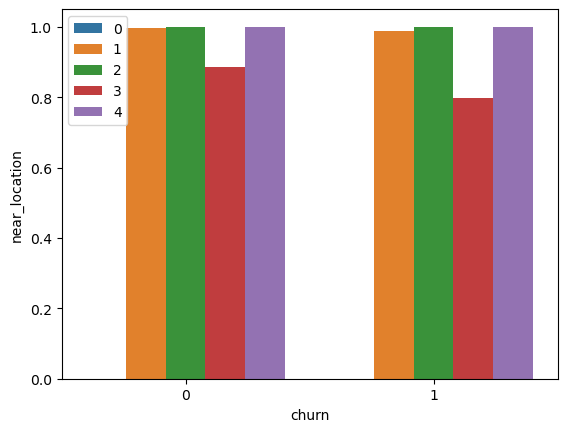

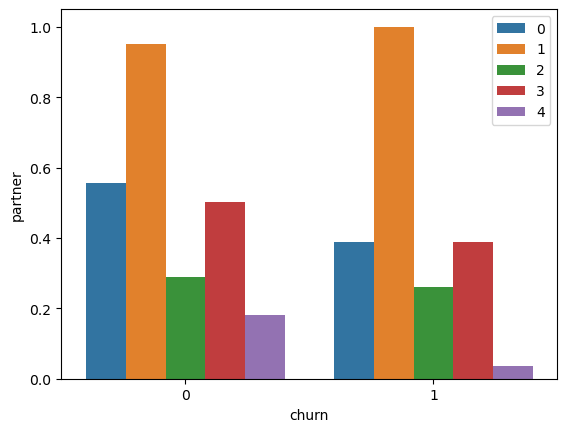

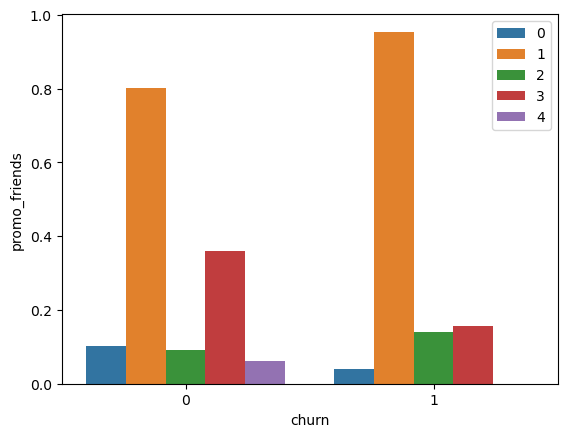

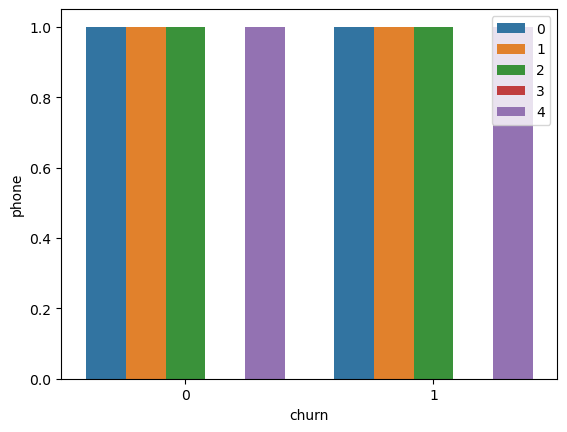

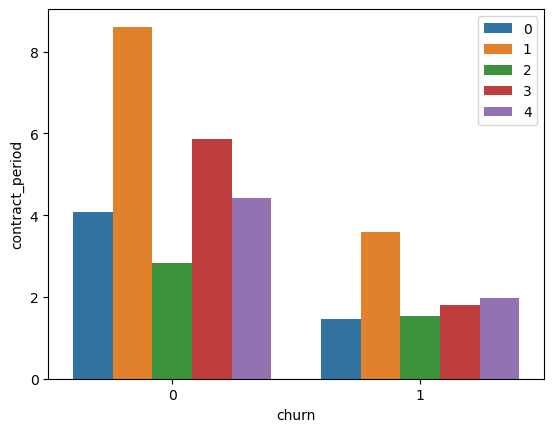

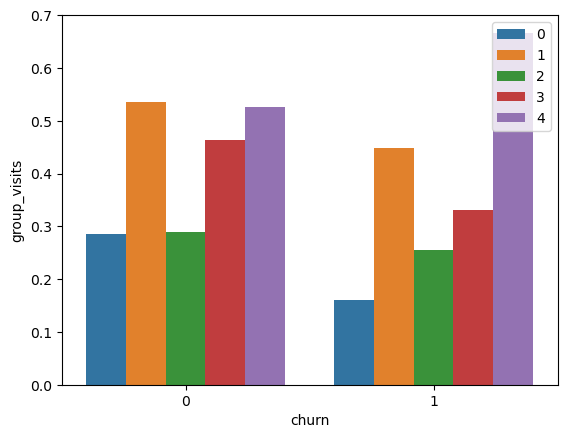

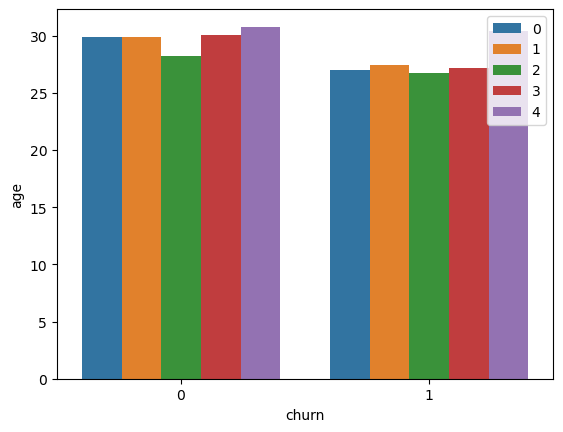

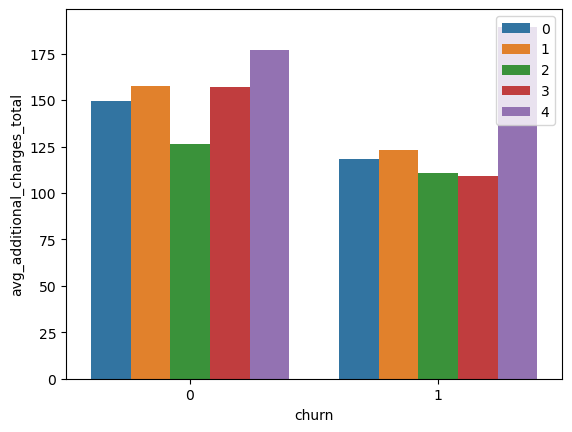

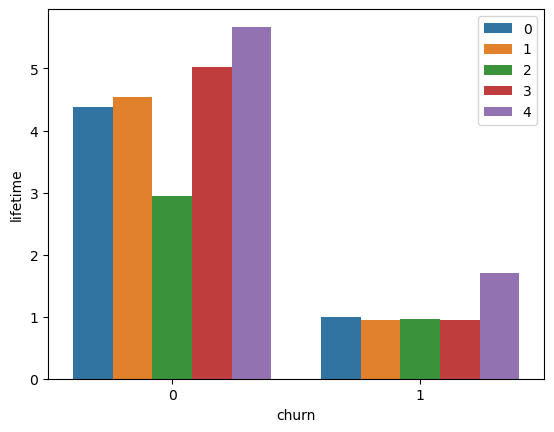

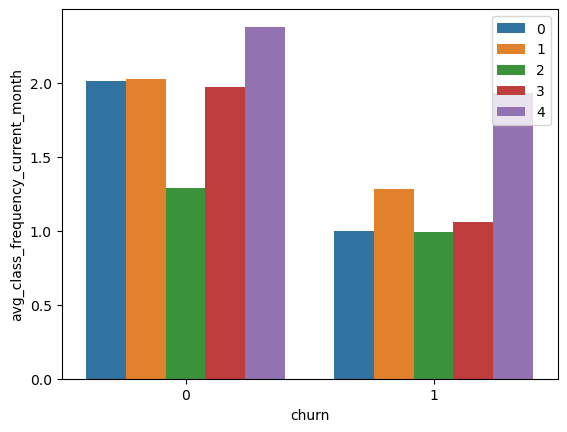

In [18]:
# Agrupando información por churn y cluster
clusters_churn = data_filtered.groupby(['churn', 'cluster_km']).mean().reset_index()

# Gráficando los valores medios de cada característica por cluster y por churn
for characteristic in clusters_churn.drop(['cluster_km', 'churn'], axis=1).columns:
    sns.barplot(data=clusters_churn, x='churn', y=characteristic, hue='cluster_km')
    plt.legend()
    plt.show()

Por ultimo calcularemos la taza de cancelación de cada cluster.

In [19]:
# Mostramos la taza de cancelación
clusters[['cluster_km','churn']].sort_values(by='churn',ascending=False)


,cluster_km,churn
2,2,0.612043
0,0,0.400000
3,3,0.266839
1,1,0.079380
4,4,0.028571


De acuerdo a estos resultados podemos llegar a las siguientes conclusiones: 

* Para los grupos 0 y 2 sus usuarios son mas propensos a cancelaciones. 

* Para los grupos 1 y 4 sus usuarios son mas leales. 

* El grupo 3 parece ser el grupo equilibrado entre cancelaciones y permanencia aunque tiene una ligera tendencia a cancelaciones. 

Todo esto es debido a que gran parte de lo siguiente: 

* Para los grupos mas leales, sus contratos son mas largos, tienden a ser de los grupos de personas de mayor edad entre la muestra,tienden a participar en sesiones grupales y son los mas longevos en el gimnasio. 

* Para los grupos con mayor probabilidad de cancelaciones se tiende a tener contratos mas cortos (1 mes, 3 meses), no suelen venir por parte de una compañía asociada, no participan tanto en las sesiones grupales y suelen cancelar a lo largo del 2 mes.

# <a id='toc7_'></a>[Conclusiones](#toc0_)

A lo largo del proyecto llegamos a los siguientes resultados. 

* El modelo de Regresión Logística es el modelo mas optimo para la predicción de posibles usuarios a cancelar. 

* Para los grupos 0 y 2 sus usuarios son mas propensos a cancelaciones. 

* Para los grupos 1 y 4 sus usuarios son mas leales. 

* El grupo 3 parece ser el grupo equilibrado entre cancelaciones y permanencia aunque tiene una ligera tendencia a cancelaciones. 

Todo esto es debido a que gran parte de lo siguiente: 

* Para los grupos mas leales, sus contratos son mas largos, tienden a ser de los grupos de personas de mayor edad entre la muestra,tienden a participar en sesiones grupales y son los mas longevos en el gimnasio. 

* Para los grupos con mayor probabilidad de cancelaciones se tiende a tener contratos mas cortos (1 mes, 3 meses), no suelen venir por parte de una compañía asociada, no participan tanto en las sesiones grupales y suelen cancelar a lo largo del 2 mes.

Para ello se sugieren las siguientes recomendaciones: 

* Promover los planes de contratos mas largos.
* Ofrecer recompensas para que los usuarios se incentiven en participar en sesiones grupales. 
* Los grupos de personas que tienden a ser mas leales son personas mayores de 28 años, enfocar las campañas publicitarias a ese segmento de personas.